# Lucas Luan Belarmino Barbosa - 2021017872

# Base de dados de artigos da Folha UOL

In [1]:
import os
from IPython.core.display import display, HTML
from google.colab import files, userdata

if not os.path.exists('/content/articles.csv'):
  if not os.path.exists('kaggle.json'):
    try:
      kaggle_key = userdata.get('kaggle_key')
      open('kaggle.json','w').write(kaggle_key)
    except:
      files.upload()

  !pip install -q kaggle

  !mkdir ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !rm kaggle.json
  !chmod 600 ~/.kaggle/kaggle.json
  !kaggle datasets download 'marlesson/news-of-the-site-folhauol'
  !unzip -qq news-of-the-site-folhauol.zip
  !rm news-of-the-site-folhauol.zip

cp: cannot stat 'kaggle.json': No such file or directory
rm: cannot remove 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/marlesson/news-of-the-site-folhauol
License(s): CC0-1.0
 99% 186M/187M [00:09<00:00, 23.3MB/s]
100% 187M/187M [00:09<00:00, 19.7MB/s]


# Instalando Biblioteca do HuggingFaces (Transformers)

In [2]:
!pip install -q datasets transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 47.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have reque

In [3]:
import transformers
print('Transformes:',transformers.__version__)
import datasets
print('Datasets:',datasets.__version__)

Transformes: 4.41.2
Datasets: 2.20.0


# Carregando Base de Dados no Format Transformes

In [4]:
import pandas as pd

df_folha = pd.read_csv('articles.csv',encoding="utf8")

df_folha.drop(["title","date","subcategory","link"],axis=1,inplace=True)
df_folha.drop_duplicates(subset=["text"],inplace=True)
df_folha.dropna(inplace=True)

df_folha.reset_index(drop=True,inplace=True)
df_folha = df_folha[df_folha['category'].isin(list(df_folha['category'].value_counts()[:7].index))]

df_folha.head()

,text,category
0,Com a possibilidade de uma condenação impedir ...,poder
1,"Para Oumou Sangaré, cantora e ativista malines...",ilustrada
2,Três reportagens da Folha foram vencedoras do ...,poder
3,A Disney divulgou na noite desta segunda-feira...,ilustrada
4,"O CBSS, banco da holding Elopar dos sócios Bra...",mercado


In [21]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, Value, ClassLabel, Features, DatasetDict

labels, class_names = pd.factorize(df_folha['category'],sort=True)
class_names = list(class_names.values)
df_folha['labels'] = labels

train, test = train_test_split(df_folha[['text','labels']].sample(n=8000),
                               test_size=0.2, random_state=42)

features = Features({"text": Value("string"),
                     "labels": ClassLabel(names=class_names)})

dataset = DatasetDict({
    "train": Dataset.from_pandas(train, features, preserve_index=False),
    "test": Dataset.from_pandas(test, features, preserve_index=False)
    })

print('dataset =',dataset)
print("dataset['train'].features =",dataset['train'].features)

id2label = {id:label for id, label in enumerate(class_names)}
label2id = {label:id for id,label in id2label.items()}
print('id2label =',id2label)
print('label2id =', label2id)

dataset = DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 6400
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 1600
    })
})
dataset['train'].features = {'text': Value(dtype='string', id=None), 'labels': ClassLabel(names=['colunas', 'cotidiano', 'esporte', 'ilustrada', 'mercado', 'mundo', 'poder'], id=None)}
id2label = {0: 'colunas', 1: 'cotidiano', 2: 'esporte', 3: 'ilustrada', 4: 'mercado', 5: 'mundo', 6: 'poder'}
label2id = {'colunas': 0, 'cotidiano': 1, 'esporte': 2, 'ilustrada': 3, 'mercado': 4, 'mundo': 5, 'poder': 6}


In [22]:
dataset['train'][7]['text'], dataset['train'][7]['labels']

('A visita de Barack Obama a Cuba sela mais um duro revés político –e moral– para o governo do presidente venezuelano, Nicolás Maduro.  O sinal mais evidente do desamparo chavista com a guinada de seu mentor ideológico e principal aliado surgiu na noite de quinta (18), quando Maduro embarcou às pressas para Havana num claro esforço para se antecipar à chegada de Obama e atrair atenções para os laços Venezuela-Cuba.  Em Havana, Maduro falou em renovar até 2030 a parceria estratégica bilateral, mas o jornal estatal cubano "Granma" só detalhou a assinatura de um acordo para combater doenças transmitidas pelo Aedes Aegypti neste ano.  Teve cara de presente de consolação a cerimônia em que o ditador cubano, Raúl Castro, homenageou o presidente venezuelano com a ordem José Martí, mais alta condecoração oficial da ilha.  Os cubanos pareciam mais concentrados nos preparativos para a visita de Obama.  Não há, por ora, indício de que a normalização entre Havana e Washington se dê às custas do la

# Modelo Neural

In [29]:
model_checkpoint = 'roberta-base'
batch_size = 16

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenizer(dataset['train'][7]['text'])

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1071 > 512). Running this sequence through the model will result in indexing errors


{'input_ids': [0, 250, 825, 102, 263, 4282, 1284, 10, 8455, 842, 2560, 475, 5655, 7252, 385, 7367, 6910, 5739, 8385, 1977, 90, 2684, 126, 242, 7654, 2383, 3840, 1021, 11738, 139, 109, 394, 242, 748, 41025, 2601, 6, 24947, 6417, 9168, 4, 1437, 384, 579, 6204, 475, 5655, 10180, 242, 109, 2694, 3914, 5191, 1855, 1469, 6377, 3137, 10, 11843, 179, 2095, 263, 842, 257, 11989, 23432, 1168, 1479, 571, 2684, 364, 5402, 27817, 2102, 8113, 15696, 257, 2750, 117, 1459, 263, 21477, 102, 36, 1366, 238, 2677, 5502, 9168, 18484, 9636, 1438, 6534, 29, 1228, 281, 3840, 22312, 15009, 17691, 139, 2714, 1990, 3381, 139, 3840, 842, 20761, 438, 1588, 271, 6534, 5851, 571, 2095, 263, 1284, 364, 23, 763, 853, 23, 225, 3381, 3849, 8906, 293, 3840, 11988, 897, 3381, 366, 6037, 12, 347, 10452, 4, 1437, 3676, 22312, 6, 9168, 14848, 1438, 2841, 21476, 271, 23, 1140, 12060, 10, 2242, 7742, 493, 3304, 6528, 1140, 571, 2426, 9526, 6, 11705, 1021, 1236, 4244, 337, 3304, 14720, 18383, 2601, 22, 534, 3917, 1916, 113, 579

# Convertendo Dataset para Tokens

In [30]:
def preprocess_function(examples):
  return tokenizer(examples['text'], truncation=True)

encoded_dataset = dataset.map(preprocess_function, batched=True)
encoded_dataset

Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 6400
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 1600
    })
})

# Ajuste-Fino

In [31]:
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

# Load pre-trained DistilBERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=len(class_names))

# Prepare data collator for padding sequences
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Define training arguments
training_args = TrainingArguments(
  output_dir = "./results",
  learning_rate = 2e-5,
  per_device_train_batch_size = 8,
  per_device_eval_batch_size = 8,
  num_train_epochs = 3,
  weight_decay = 0.01,
  metric_for_best_model = "accuracy",
  evaluation_strategy = "epoch",
  logging_strategy = "epoch"
)

# Define Trainer object for training the model
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = encoded_dataset['train'],
    eval_dataset = encoded_dataset['test'],
    tokenizer = tokenizer,
    data_collator = data_collator,
)

# Train the model
trainer.train()

# Save the trained model
trainer.save_model('model')

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.874300,0.534988
2,0.468600,0.532185
3,0.313800,0.579594


# Avaliando o Modelo

In [32]:
outputs = trainer.predict(encoded_dataset['test'])

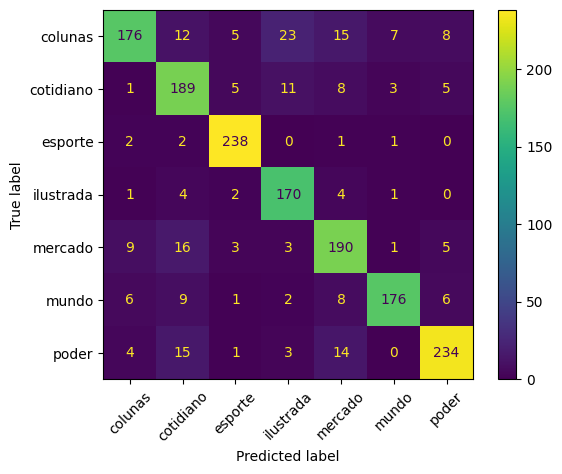

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = encoded_dataset['test'].features['labels'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [34]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=labels))

              precision    recall  f1-score   support

     colunas       0.88      0.72      0.79       246
   cotidiano       0.77      0.85      0.81       222
     esporte       0.93      0.98      0.95       244
   ilustrada       0.80      0.93      0.86       182
     mercado       0.79      0.84      0.81       227
       mundo       0.93      0.85      0.89       208
       poder       0.91      0.86      0.88       271

    accuracy                           0.86      1600
   macro avg       0.86      0.86      0.86      1600
weighted avg       0.86      0.86      0.86      1600

